# Optical Pulse Propagation

In this notebook, the case of generalized nonlinear Schrödinger equations is studied, in the context of a ultra-short pulse of light, typically occuring in optical fibers.

The governing equation was derived starting from Maxwell's wave equation in 1D, and is a PDE known as a generalized nonlinear Schrödinger equation (GNLSE):

$$ \frac{\partial u}{\partial x} - \sum_{k=2}^{\infty} \alpha_k \frac{\partial^k u}{\partial t^k} = \left(i - \frac{\partial}{\partial t}\right) u \int_{-\infty}^{\infty} r(t') | u(t') |^2 \text{d} t' \\
r(t) = a \delta(t) + b \exp (ct) \sin (dt) \Theta(t) $$

This describes the variation of the complex envelope $u(x, t)$ of the pulse. This equation is the nondimenionalized version (done with soliton scalings). The delta-function component of the RHS integral is called the cubic Kerr nonlinearity. And the r(t) function is called the Raman Kernel.

The ($\alpha_{k}, a, b, c, d$) describe the polarization response and were determined empirically.

The data is obtained using the Callaham written code, itself using the code from J.C. Travers, M.H Frosz and J.M. Dudley (2009) which can be found [here](https://github.com/jtravs/SCGBookCode).

In [78]:
import scipy.io as sio
import sys
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn as sk

# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf

## 1. Load the data

From the governing , and the paper, the terms needed are:
- $\frac{\partial u}{\partial x}$, u_x
- Multiple order time derivatives of u, which go up to 10 in the data, and 6 in the paper.
- u, the propagation speed

As discussed in the supplementary information and from the ```gnlse_terms.m``` code, the Raman kernel and cubic Kerr nonlinearity terms are obtained as:
- R, is the going to be be the Raman term without the cubic Kerr nonlinearity.
- Kerr, or $|u|^{2}u$, will be the cubic Kerr nonlinearity.


In [79]:
data = sio.loadmat("../Data/gnlse_nondim.mat")

# Extract the variables needed:
u = data["u"]
u_x = data["ux"]
u_t = data["du_dt"][0, 1]
u_tt = data["du_dt"][0, 2]
u_3t = data["du_dt"][0, 3]
u_4t = data["du_dt"][0, 4]
u_5t = data["du_dt"][0, 5]
u_6t = data["du_dt"][0, 6]

R = data["raman"]
u2u = data["kerr"]

In [80]:
# print shapes
print(u.shape)
print(u_x.shape)
print(u_t.shape)
print(u_tt.shape)
print(u_3t.shape)
print(u_4t.shape)
print(u_5t.shape)
print(u_6t.shape)
print(R.shape)
print(u2u.shape)

(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)
(1000, 8192)


In [81]:
# Visualise the terms in space
x = data["x"]
t = data["t"]

From the test_Dudley.m code, the visualisation obtained in the callaham paper is done by putting the variables on a log-scale. Following that matlab code, the following visualisation is obtained:

/var/folders/kt/m5clbvx50n37tx6gpnr84gd80000gn/T/ipykernel_27291/1800687574.py:3: RuntimeWarning: divide by zero encountered in log10
  field = 10 * np.log10(np.abs(u) ** 2)


Text(0.5, 1.0, 'u (in dB)')

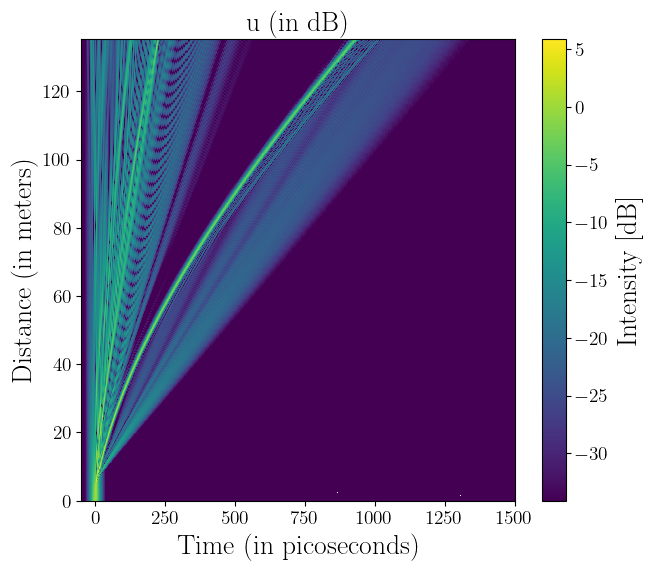

In [82]:
# Plot one of the terms: u
fig = plt.figure(figsize=(7, 6))
field = 10 * np.log10(np.abs(u) ** 2)
max_u = np.max(field)
plt.pcolormesh(t, x, field, vmin=max_u - 40, vmax=max_u)
plt.xlim([-50, 1500])
cbar = plt.colorbar()
cbar.set_label("Intensity [dB]")
plt.xlabel("Time (in picoseconds)")
plt.ylabel("Distance (in meters)")
plt.title("u (in dB)")

## 2. Getting the features

In [83]:
labels = [
    r"$u_{t}^{(2)}$",
    r"$u_{t}^{(3)}$",
    r"$u_{t}^{(4)}$",
    r"$u_{t}^{(5)}$",
    r"$u_{t}^{(6)}$",
    r"$|u|^{2}$",
    r"$R$",
    r"$u_{x}$",
]

In [84]:
# Get the terms in an array
# Because it is of little interest, remove all points for t < 200
idx = np.where(t > -200)[1][0]

u_x_sub = u_x[:, idx:]
u_tt_sub = u_tt[:, idx:]
u_3t_sub = u_3t[:, idx:]
u_4t_sub = u_4t[:, idx:]
u_5t_sub = u_5t[:, idx:]
u_6t_sub = u_6t[:, idx:]
R_sub = R[:, idx:]
u2u_sub = u2u[:, idx:]

# Flatten the terms
u_x_sub = u_x_sub.flatten()
u_tt_sub = u_tt_sub.flatten()
u_3t_sub = u_3t_sub.flatten()
u_4t_sub = u_4t_sub.flatten()
u_5t_sub = u_5t_sub.flatten()
u_6t_sub = u_6t_sub.flatten()
R_sub = R_sub.flatten()
u2u_sub = u2u_sub.flatten()

In [85]:
# Create the array according to Fig 9 in the supplementary informations
features = np.array(
    np.array(
        [u_tt_sub, u_3t_sub, u_4t_sub, u_5t_sub, u_6t_sub, u2u_sub, R_sub, u_x_sub]
    ).T
)
nfeatures = features.shape[1]

# Because complex values are not supported in the GMM,
# we will use the real part of the features for now
features = np.real(features)

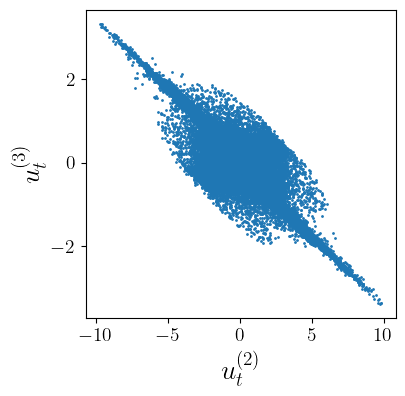

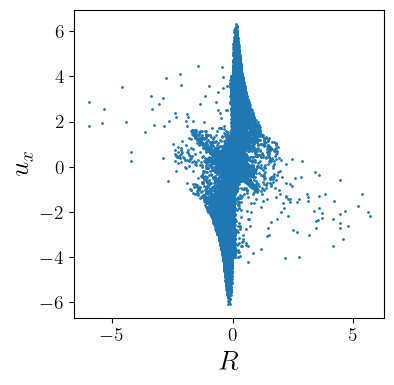

In [86]:
plt.figure(figsize=(4, 4))

# Plot the features
plt.scatter(features[:, 0], features[:, 1], s=1)
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(features[:, 6], features[:, 7], s=1)
plt.xlabel(labels[6])
plt.ylabel(labels[7])
plt.show()

## 3. GMM clustering

In [87]:
seed = 75016
np.random.seed(seed)

# Fit the model on 50% of the data
frac = 0.15
features_train, _ = sk.model_selection.train_test_split(
    features, train_size=frac, random_state=seed
)

n_clusters = 6
model = GaussianMixture(n_components=n_clusters, random_state=seed)
model.fit(features_train)

GaussianMixture(n_components=6, random_state=75016)

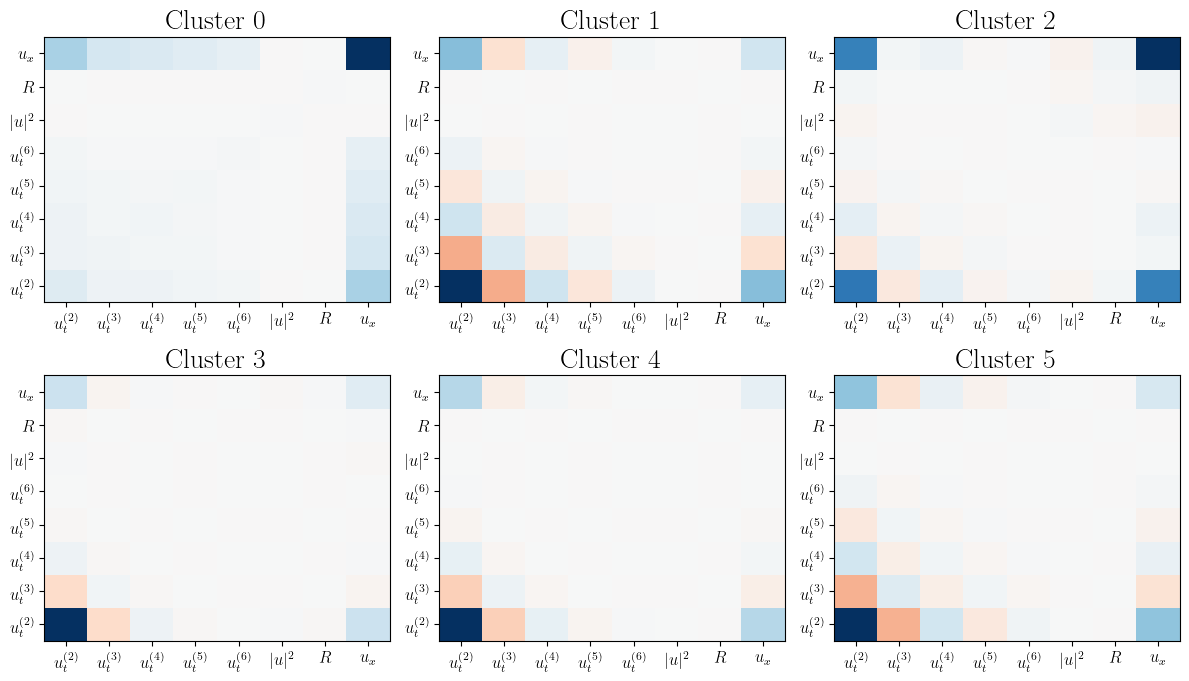

In [88]:
pf.plot_cov_mat(model, nfeatures, n_clusters, labels, "GMM")

In [89]:
# Predict the clusters for the entire dataset
cluster_idx = model.predict(features)

In [90]:
# Define a clustermap
nx = len(x.flatten())
nt = len(t[0, idx:].flatten())

clustermap = cluster_idx.reshape(nx, nt)

In [91]:
# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)

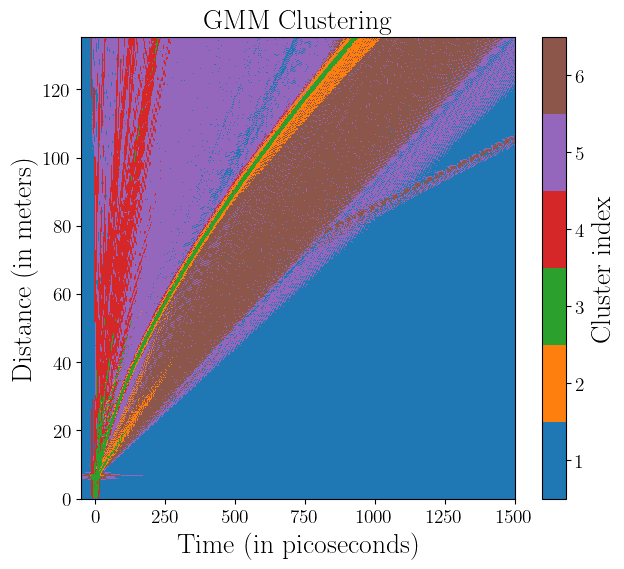

In [92]:
# Plot the clustermap
def plot_clustering_optics(clustermap, x, t, n_clusters):
    plt.figure(figsize=(7, 6))
    plt.pcolormesh(t, x, clustermap + 1, cmap=cm, vmin=-0.5, vmax=cm.N - 0.5)
    cbar = plt.colorbar(
        boundaries=np.arange(0.5, n_clusters + 1.5), ticks=np.arange(0, n_clusters + 1)
    )
    cbar.set_label("Cluster index")
    plt.xlim([-50, 1500])
    plt.xlabel("Time (in picoseconds)")
    plt.ylabel("Distance (in meters)")
    plt.title("GMM Clustering")
    plt.show()


t_sub = t[:, idx:]

plot_clustering_optics(clustermap, x, t_sub, n_clusters)

## 3. Sparse PCA identification of the active terms

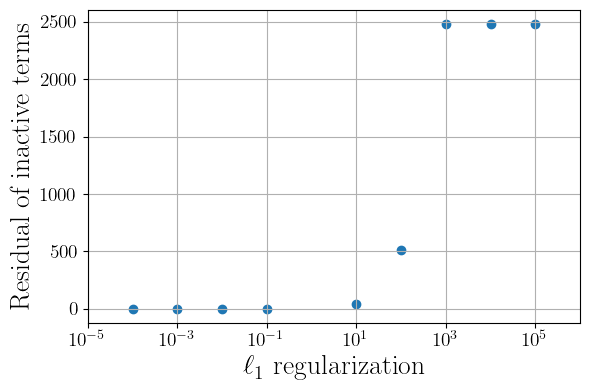

In [93]:
alphas = [1e-4, 1e-3, 1e-2, 0.1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])

for k, alpha in enumerate(alphas):
    for i in range(n_clusters):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alphas[k], random_state=seed)
        spca.fit(cluster_features)

        # Identify active and inactive terms
        active_terms = np.where(spca.components_[0] != 0)[0]
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err[k] += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))


pf.plot_spca_residuals(alphas, err)

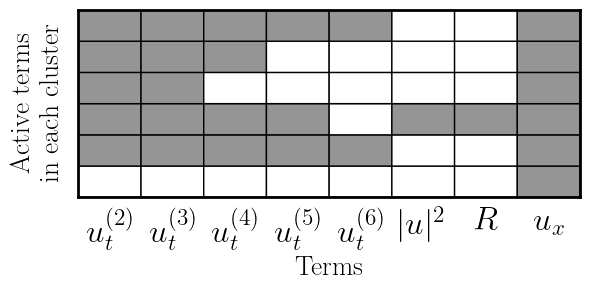

In [94]:
# Set the alpha regularization term to 40
alpha = 10

# Initialize the sparse PCA model
spca_model = np.zeros((n_clusters, nfeatures))

for i in range(n_clusters):
    feature_idx = np.where(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
    spca.fit(cluster_features)

    active_terms = np.where(spca.components_[0] != 0)[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

pf.plot_active_terms(spca_model, labels)

## 4. Get Unique Dominant Balance Models

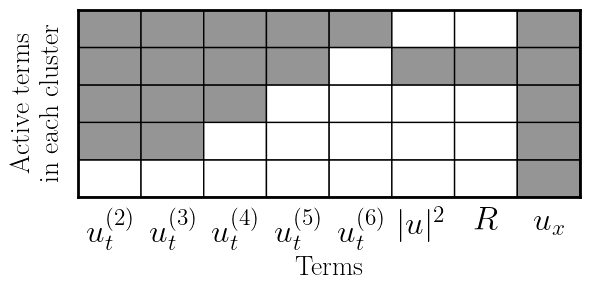

In [96]:
# Convert the spca_model array to a dataframe
spca_temp = pd.DataFrame(spca_model.copy())

# Group the balance models by the values of all columns
grouped_models = spca_temp.groupby(np.arange(nfeatures).tolist())
grouped_models = grouped_models.groups.items()

# Combine balance models that have identical active terms
# For each balance model, the spca models that have the same active terms
# are given the same index
balance_models = pd.DataFrame(np.zeros((len(grouped_models), nfeatures)))

model_idx = np.zeros(len(spca_model), dtype=int)
for i, model in enumerate(grouped_models):
    idx = model[1].to_list()
    model_idx[idx] = i
    balance_models.loc[i] = spca_temp.loc[idx[0]].to_numpy()

# Convert the balance models to a numpy array
balance_models = balance_models.drop_duplicates(keep="first")
balance_models = balance_models.to_numpy()
nmodels = balance_models.shape[0]

# Plot a grid of the active terms
pf.plot_active_terms(balance_models, labels)

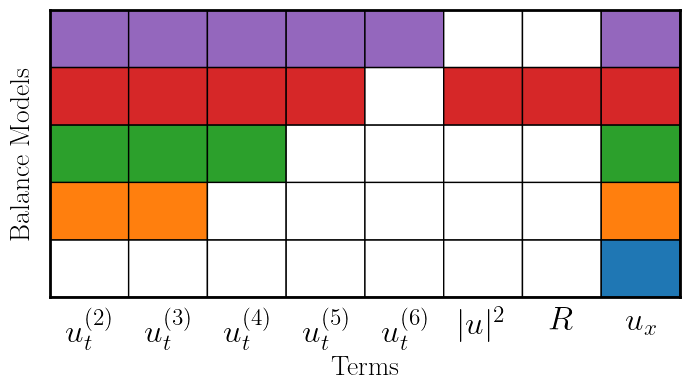

In [97]:
# Plot the balance models in a grid

balance_grid = balance_models.copy()
nmodels = balance_models.shape[0]
gridmask = np.where(balance_grid == 0)


cluster_number = np.arange(nmodels).reshape(nmodels, 1)
balance_grid = balance_grid * cluster_number + 1
balance_grid[gridmask] = 0

# Delete the terms that are inactive in all clusters
grid_mask = np.where(np.all(balance_grid == 0, axis=0))[0]
balance_grid = np.delete(balance_grid, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)


pf.plot_balance_models(balance_grid, grid_labels)

In [98]:
# Assign the new cluster indices
balance_idx = np.array([model_idx[i] for i in cluster_idx])

# Define a new clustermap
balance_clustermap = balance_idx.reshape(nx, nt)

In [99]:
balance_clustermap.shape, x.shape, t_sub.shape

((1000, 4571), (1000, 1), (1, 4571))

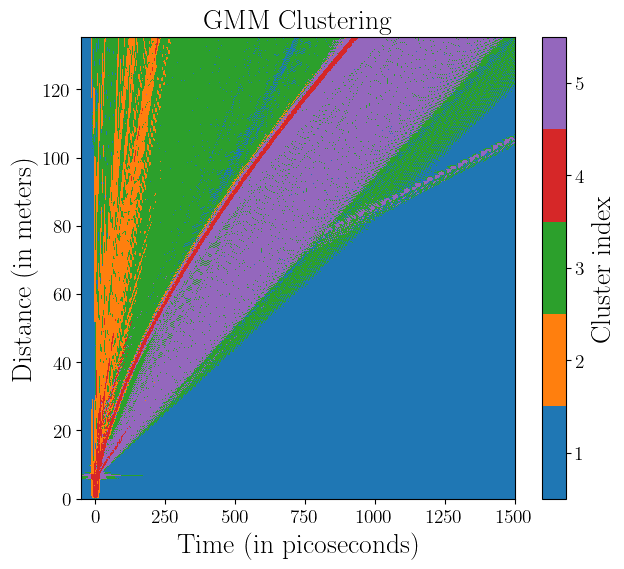

In [100]:
plot_clustering_optics(balance_clustermap, x, t_sub, nmodels)

(2207793,) (2207793,) (2207793,) (2207793,)
False
False
False
False


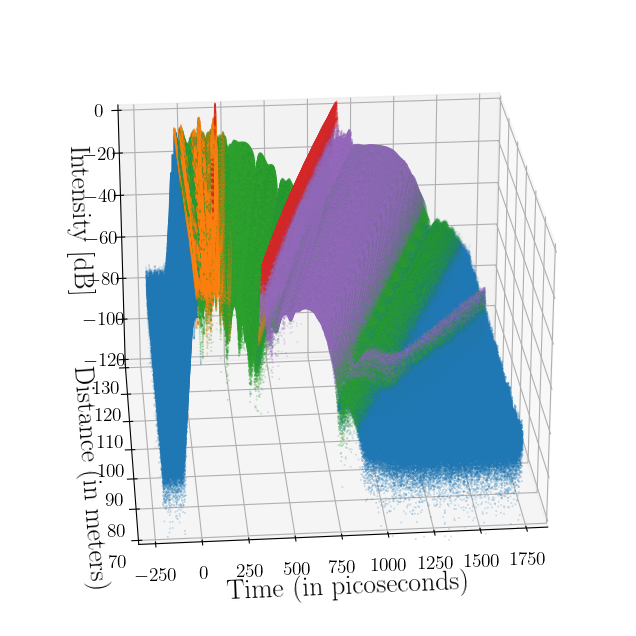

In [101]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns

# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)
cm.set_bad("darkgrey")

t_idx = np.where(t > -200)[1][0]
x_idx = np.where(x > 70)[0][0]

T, X = np.meshgrid(t[0, t_idx:], x[x_idx:])

t_flat = T.flatten()
x_flat = X.flatten()
field_flat = field[x_idx:, t_idx:].flatten()
balance_clustermap_flat = balance_clustermap[x_idx:, :].flatten()

print(t_flat.shape, x_flat.shape, field_flat.shape, balance_clustermap_flat.shape)

# Cehck for any nans

print(np.isnan(t_flat).any())
print(np.isnan(x_flat).any())
print(np.isnan(field_flat).any())
print(np.isnan(balance_clustermap_flat).any())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    t_flat,
    x_flat,
    field_flat,
    c=balance_clustermap_flat + 1,
    vmin=-0.5,
    vmax=cm.N - 0.5,
    cmap=cm,
    s=0.02,
)

ax.set_xlabel("Time (in picoseconds)")
ax.set_ylabel("Distance (in meters)")
ax.set_zlabel("Intensity [dB]")

ax.set_ylim([70, 130])
ax.set_zlim([-120, 0])

ax.view_init(25, 265)

plt.show()